In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

plt.rcParams["figure.figsize"] = (10,5)

1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    """предсказание с помощью градиентного бустинга"""
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    """среднеквадратичная ошибка"""
    return (sum((y_real - prediction) ** 2)) / len(y_real)

In [7]:
def bias(y, z):
    """смещение для L2-loss"""
    return - 2 * (z - y)

In [8]:
def gb_fit(DecisionTreeClass, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    """обучение градиентного бустинга"""
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeClass(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    """ошибка алгоритма на тренировочной и тестовой выборках"""
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из\t{n_trees} деревьев\tглубиной {max_depth}'
          f'\tс шагом {eta}\tна тренировочной выборке:\t{round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из\t{n_trees} деревьев\tглубиной {max_depth}'
          f'\tс шагом {eta}\tна   тестовой    выборке:\t{round(mean_squared_error(y_test, test_prediction))}')

In [10]:
errors = {
    'train': {'ETA': {}, 'MAX_DEPTH': {} },
    'test': {'ETA': {}, 'MAX_DEPTH': {} },
}

In [11]:
n_trees = 10
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
max_depth = 3
for eta in (0.5, 0.05, 0.005):
    trees, errors['train']['ETA'][eta], errors['test']['ETA'][eta] = \
    gb_fit(DecisionTreeRegressor, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на тренировочной выборке:	1095.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на   тестовой    выборке:	4845.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.05	на тренировочной выборке:	6281.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.05	на   тестовой    выборке:	5836.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.005	на тренировочной выборке:	25184.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.005	на   тестовой    выборке:	22519.0


In [12]:
n_trees = 10
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
eta = 0.5
for max_depth in (2, 3, 5, 7):
    trees, errors['train']['MAX_DEPTH'][max_depth], errors['test']['MAX_DEPTH'][max_depth] = \
    gb_fit(DecisionTreeRegressor, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из	10 деревьев	глубиной 2	с шагом 0.5	на тренировочной выборке:	1916.0
Ошибка алгоритма из	10 деревьев	глубиной 2	с шагом 0.5	на   тестовой    выборке:	3731.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на тренировочной выборке:	1095.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на   тестовой    выборке:	4845.0
Ошибка алгоритма из	10 деревьев	глубиной 5	с шагом 0.5	на тренировочной выборке:	144.0
Ошибка алгоритма из	10 деревьев	глубиной 5	с шагом 0.5	на   тестовой    выборке:	5928.0
Ошибка алгоритма из	10 деревьев	глубиной 7	с шагом 0.5	на тренировочной выборке:	3.0
Ошибка алгоритма из	10 деревьев	глубиной 7	с шагом 0.5	на   тестовой    выборке:	4974.0


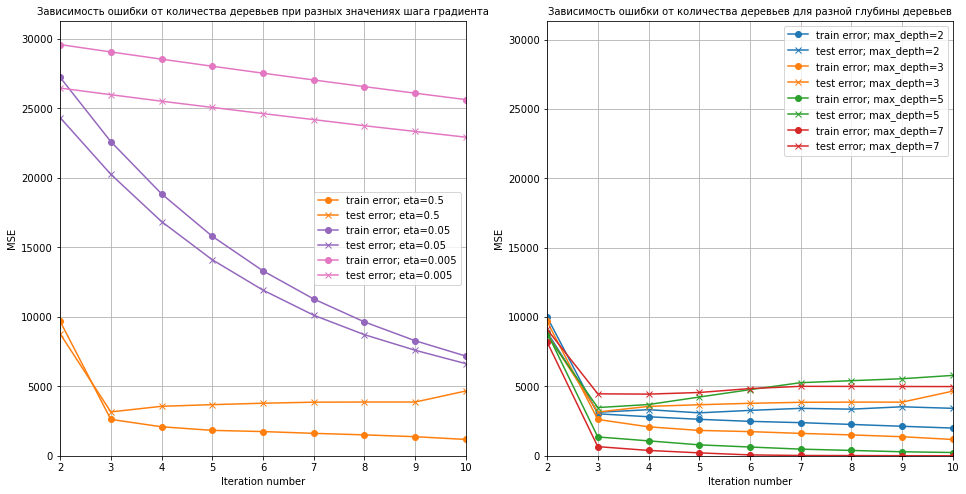

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

x = list(range(1, n_trees+1))

ax1.set_title('Зависимость ошибки от количества деревьев при разных значениях шага градиента', fontsize=10)
N = 1
for eta in errors['train']['ETA'].keys():
    ax1.plot(x, errors['train']['ETA'][eta], f'C{N}', marker='o', label=f'train error; {eta=}')
    ax1.plot(x, errors['test']['ETA'][eta], f'C{N}', marker='x', label=f'test error; {eta=}')
    N *= 4

ax2.set_title('Зависимость ошибки от количества деревьев для разной глубины деревьев', fontsize=10)
N = 0
for max_depth in errors['train']['MAX_DEPTH'].keys():
    ax2.plot(x, errors['train']['MAX_DEPTH'][max_depth], f'C{N}', marker='o', label=f'train error; {max_depth=}')
    ax2.plot(x, errors['test']['MAX_DEPTH'][max_depth], f'C{N}', marker='x', label=f'test error; {max_depth=}')
    N += 1
    
for ax in (ax1, ax2):
    ax.set_xlabel('Iteration number')
    ax.set_ylabel('MSE')
    ax.set_xlim(2, n_trees)
    ax.set_ylim(bottom=0)
    # ax.set_yscale("log")
    ax.grid()
    ax.legend();

2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [14]:
def sgb_fit(DecisionTreeClass, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    """обучение стохастического градиентного бустинга"""
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    n_2 = X_train.shape[0] // 2
    
    for i in range(n_trees):
        
        even = 1 if (i % 2) else 0
        start = n_2 * even
        stop = start + n_2
        XX_train = X_train[start:stop, :]
        yy_train = y_train[start:stop]
        
        tree = DecisionTreeClass(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(XX_train, yy_train)
            
            train_errors.append(mean_squared_error(yy_train, gb_predict(XX_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(XX_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(XX_train, bias(yy_train, z_train))
            
            train_errors.append(mean_squared_error(yy_train, gb_predict(XX_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [15]:
errors = {
    'train': {'ETA': {}, 'MAX_DEPTH': {} },
    'test': {'ETA': {}, 'MAX_DEPTH': {} },
}

In [16]:
n_trees = 10
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
max_depth = 3
for eta in (0.5, 0.05, 0.005):
    trees, errors['train']['ETA'][eta], errors['test']['ETA'][eta] = \
    sgb_fit(DecisionTreeRegressor, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на тренировочной выборке:	2676.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на   тестовой    выборке:	4054.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.05	на тренировочной выборке:	6336.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.05	на   тестовой    выборке:	5861.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.005	на тренировочной выборке:	25188.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.005	на   тестовой    выборке:	22513.0


In [17]:
n_trees = 10
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
eta = 0.5
for max_depth in (2, 3, 5, 7):
    trees, errors['train']['MAX_DEPTH'][max_depth], errors['test']['MAX_DEPTH'][max_depth] = \
    sgb_fit(DecisionTreeRegressor, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из	10 деревьев	глубиной 2	с шагом 0.5	на тренировочной выборке:	2747.0
Ошибка алгоритма из	10 деревьев	глубиной 2	с шагом 0.5	на   тестовой    выборке:	3952.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на тренировочной выборке:	2676.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на   тестовой    выборке:	4054.0
Ошибка алгоритма из	10 деревьев	глубиной 5	с шагом 0.5	на тренировочной выборке:	2386.0
Ошибка алгоритма из	10 деревьев	глубиной 5	с шагом 0.5	на   тестовой    выборке:	12686.0
Ошибка алгоритма из	10 деревьев	глубиной 7	с шагом 0.5	на тренировочной выборке:	3588.0
Ошибка алгоритма из	10 деревьев	глубиной 7	с шагом 0.5	на   тестовой    выборке:	16710.0


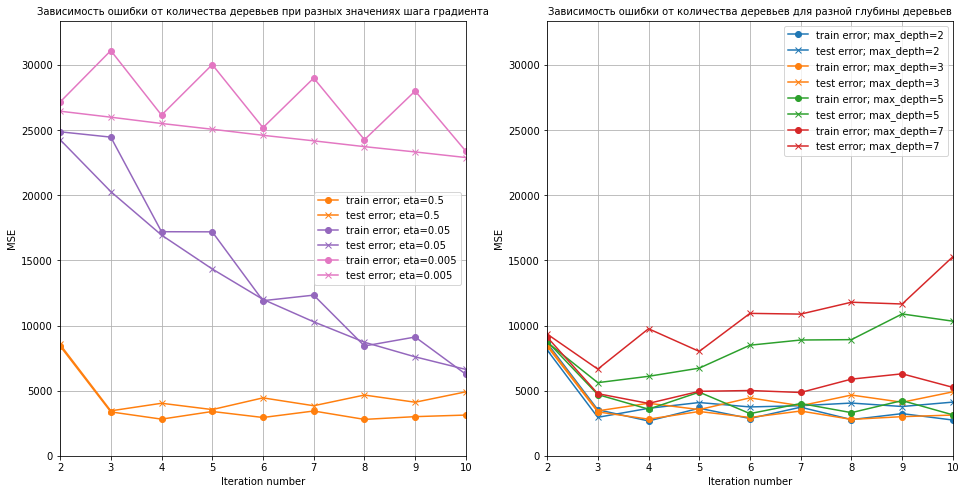

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

x = list(range(1, n_trees+1))

ax1.set_title('Зависимость ошибки от количества деревьев при разных значениях шага градиента', fontsize=10)
N = 1
for eta in errors['train']['ETA'].keys():
    ax1.plot(x, errors['train']['ETA'][eta], f'C{N}', marker='o', label=f'train error; {eta=}')
    ax1.plot(x, errors['test']['ETA'][eta], f'C{N}', marker='x', label=f'test error; {eta=}')
    N *= 4

ax2.set_title('Зависимость ошибки от количества деревьев для разной глубины деревьев', fontsize=10)
N = 0
for max_depth in errors['train']['MAX_DEPTH'].keys():
    ax2.plot(x, errors['train']['MAX_DEPTH'][max_depth], f'C{N}', marker='o', label=f'train error; {max_depth=}')
    ax2.plot(x, errors['test']['MAX_DEPTH'][max_depth], f'C{N}', marker='x', label=f'test error; {max_depth=}')
    N += 1
    
for ax in (ax1, ax2):
    ax.set_xlabel('Iteration number')
    ax.set_ylabel('MSE')
    ax.set_xlim(2, n_trees)
    ax.set_ylim(bottom=0)
    # ax.set_yscale("log")
    ax.grid()
    ax.legend();

3. (\*) Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

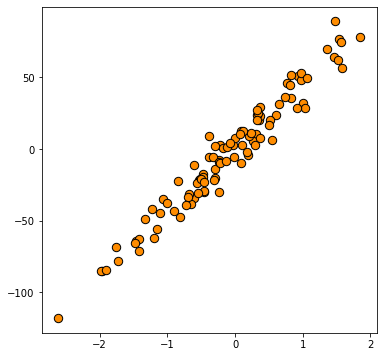

In [19]:
from sklearn import datasets

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70);

In [20]:
def gini(labels):
    """критерий Джини"""
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1 # коэффициент неопределённости Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

In [21]:
class Node:
    """узел дерева"""
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [22]:
class Leaf:
    """лист дерева"""
    
    def __init__(self, data, labels, regression):
        self.data = data
        self.labels = labels
        self.regression = regression
        self.prediction = self.predict()
        
    def predict(self):
        if self.regression:
            prediction = np.mean(self.labels)  # среднее значение по выборке
        else:
            # подсчёт количества объектов разных классов
            classes = {}  # сформируем словарь "класс: количество объектов"
            for label in self.labels:
                if label not in classes:
                    classes[label] = 0 
                classes[label] += 1
            # найдём класс, количество объектов которого будет максимальным в этом листе и вернём его
            prediction = max(classes, key=classes.get)
        return prediction

In [23]:
class MyDecisionTree:
    def __init__(self, random_state=None, min_leaf=1, max_depth=10**9, max_leaf_nodes=10**9, regression=True):
        """
        конструктор дерева

        :param min_leaf: минимальное количество объектов в листе
        :param max_depth: максимальная глубина дерева
        :param max_leaf_nodes: максимальное количество листьев
        :param inf_crit_func: критерий информативности
        """
        self.root = None
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.max_leaf_nodes = max_leaf_nodes
        self.regression = regression
        self.inf_crit_func = np.var if regression else gini  # критерий информативности
    
    def quality(self, left_labels, right_labels, current_inf_crit):
        """расчёт качества"""
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])  
        return current_inf_crit - p * self.inf_crit_func(left_labels) - (1 - p) * self.inf_crit_func(right_labels)
    
    def split(self, data, labels, index, t):
        """разбиение датасета в узле"""

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    def find_best_split(self, data, labels):
        """нахождение наилучшего разбиения"""

        current_inf_crit = self.inf_crit_func(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                # пропускаем разбиения, в которых в узле остаётся менее min_leaf объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_inf_crit)

                # выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    def build_tree(self, data, labels, _leaves=0, _branches=0, _depth=0):
        """
        построение дерева с помощью рекурсивной функции

        :param data: данные
        :param labels: метки
        :return: узел дерева, кол-во листьев, кол-во ветвей
        """

        quality, t, index = self.find_best_split(data, labels)

        # Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if (quality == 0) or ((self.max_leaf_nodes - _leaves - _branches) < 2) or (_depth >= self.max_depth):
            _leaves += 1
            return Leaf(data, labels, regression=self.regression), _leaves, _branches

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        _branches += 1
        true_branch, _leaves, _branches = self.build_tree(true_data, true_labels, _leaves, _branches, _depth+1)
        _branches -= 1
        false_branch, _leaves, _branches = self.build_tree(false_data, false_labels, _leaves, _branches, _depth+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.root = Node(index, t, true_branch, false_branch)
        return self.root, _leaves, _branches
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
        
    def fit(self, X, y):
        reg_tree, *_ = self.build_tree(X, y)
        return reg_tree
    
    def predict(self, X):
        classes = []
        for obj in X:
            prediction = self.classify_object(obj, self.root)
            classes.append(prediction)
        return classes

In [24]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
errors = {
    'train': {'ETA': {}, 'MAX_DEPTH': {} },
    'test': {'ETA': {}, 'MAX_DEPTH': {} },
}

In [27]:
n_trees = 10
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
max_depth = 3
for eta in (0.5, 0.05, 0.005):
    trees, errors['train']['ETA'][eta], errors['test']['ETA'][eta] = \
    gb_fit(MyDecisionTree, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на тренировочной выборке:	1095.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на   тестовой    выборке:	5562.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.05	на тренировочной выборке:	6281.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.05	на   тестовой    выборке:	5829.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.005	на тренировочной выборке:	25184.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.005	на   тестовой    выборке:	22518.0


In [28]:
n_trees = 10
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
eta = 0.5
for max_depth in (2, 3, 5, 7):
    trees, errors['train']['MAX_DEPTH'][max_depth], errors['test']['MAX_DEPTH'][max_depth] = \
    gb_fit(MyDecisionTree, n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из	10 деревьев	глубиной 2	с шагом 0.5	на тренировочной выборке:	1916.0
Ошибка алгоритма из	10 деревьев	глубиной 2	с шагом 0.5	на   тестовой    выборке:	3710.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на тренировочной выборке:	1095.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на   тестовой    выборке:	5562.0
Ошибка алгоритма из	10 деревьев	глубиной 5	с шагом 0.5	на тренировочной выборке:	144.0
Ошибка алгоритма из	10 деревьев	глубиной 5	с шагом 0.5	на   тестовой    выборке:	5937.0
Ошибка алгоритма из	10 деревьев	глубиной 7	с шагом 0.5	на тренировочной выборке:	3.0
Ошибка алгоритма из	10 деревьев	глубиной 7	с шагом 0.5	на   тестовой    выборке:	4598.0


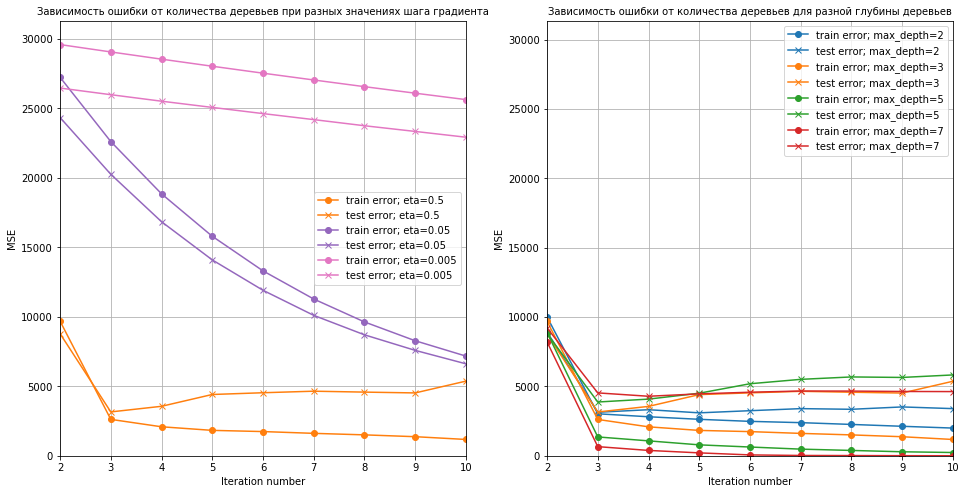

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

x = list(range(1, n_trees+1))

ax1.set_title('Зависимость ошибки от количества деревьев при разных значениях шага градиента', fontsize=10)
N = 1
for eta in errors['train']['ETA'].keys():
    ax1.plot(x, errors['train']['ETA'][eta], f'C{N}', marker='o', label=f'train error; {eta=}')
    ax1.plot(x, errors['test']['ETA'][eta], f'C{N}', marker='x', label=f'test error; {eta=}')
    N *= 4

ax2.set_title('Зависимость ошибки от количества деревьев для разной глубины деревьев', fontsize=10)
N = 0
for max_depth in errors['train']['MAX_DEPTH'].keys():
    ax2.plot(x, errors['train']['MAX_DEPTH'][max_depth], f'C{N}', marker='o', label=f'train error; {max_depth=}')
    ax2.plot(x, errors['test']['MAX_DEPTH'][max_depth], f'C{N}', marker='x', label=f'test error; {max_depth=}')
    N += 1
    
for ax in (ax1, ax2):
    ax.set_xlabel('Iteration number')
    ax.set_ylabel('MSE')
    ax.set_xlim(2, n_trees)
    ax.set_ylim(bottom=0)
    # ax.set_yscale("log")
    ax.grid()
    ax.legend();

---

In [30]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'


def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")

In [31]:
mdtr = MyDecisionTree(min_leaf=5, regression=True)

In [32]:
reg_tree = mdtr.fit(regression_data, regression_labels)

In [33]:
print_tree(reg_tree)

УЗЕЛ: индекс = 0, порог = -0.23
--> Левая ветка:
   УЗЕЛ: индекс = 0, порог = -1.15
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -1.72
      --> Левая ветка:
          ЛИСТ: прогноз = -86.65799231942276, объектов = 6
      --> Правая ветка:
          ЛИСТ: прогноз = -59.19707310267859, объектов = 8
   --> Правая ветка:
      УЗЕЛ: индекс = 0, порог = -0.6
      --> Левая ветка:
         УЗЕЛ: индекс = 0, порог = -0.81
         --> Левая ветка:
             ЛИСТ: прогноз = -38.39087022581251, объектов = 6
         --> Правая ветка:
             ЛИСТ: прогноз = -35.27725517230256, объектов = 5
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = -0.46
         --> Левая ветка:
            УЗЕЛ: индекс = 0, порог = -0.5
            --> Левая ветка:
                ЛИСТ: прогноз = -21.434094087907813, объектов = 6
            --> Правая ветка:
                ЛИСТ: прогноз = -23.95001980586166, объектов = 5
         --> Правая ветка:
            УЗЕЛ: индекс = 0, порог = -0.3


In [34]:
predicted_labels = mdtr.predict(regression_data)

In [35]:
def calc_mse(y, y_pred):
    """средняя квадратическая ошибка"""
    err = np.mean((y - y_pred)**2)
    return err

def calc_mae(y, y_pred):
    """средняя абсолютная ошибка"""
    err = np.mean(np.abs(y - y_pred))
    return err

mse = calc_mse(regression_labels, predicted_labels)
mae = calc_mae(regression_labels, predicted_labels)

print(f"MSE = {mse}\nMAE = {mae}")

MSE = 69.42120503167011
MAE = 6.418628709407379


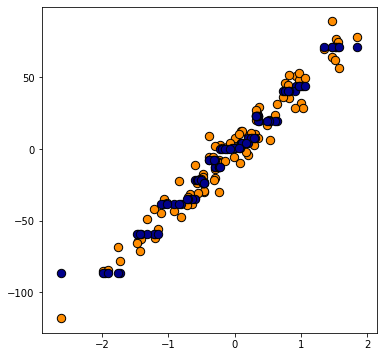

In [36]:
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70)
plt.scatter(regression_data, predicted_labels, c='darkblue', edgecolor='black', s=70);